In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim

from torchtext.data import Field, BucketIterator, TabularDataset, BucketIterator,Example

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import pandas as pd

import random
import math
import time
import os

path = '/home/edshkim98/nlp/classification/bbc/' #location of dataset
source_folder = '/home/edshkim98/nlp/classification/' #location of code file
destination_folder = source_folder+'pretrained' #location of saved pretrained model

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import glob

In [50]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [51]:
data = path+'/News Articles/'
data2 = path+'/Summaries/'

os.listdir(data)

['business', 'tech', 'politics', 'sport', 'entertainment']

# MODELS

In [83]:
class LSTM(nn.Module):

    def __init__(self, dimension=256):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(text_field.vocab.vectors, freeze=False)
        #self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.2)

        self.fc = nn.Linear(2*dimension, 5)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        print(output.shape)
        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        print(out_forward.shape)
        out_reverse = output[:, 0, self.dimension:]
        print(out_reverse.shape)
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        print(out_reduced.shape)
        text_fea = self.drop(out_reduced)

        out = self.fc(text_fea)
        return out
    
class LSTM2(nn.Module):

    def __init__(self, dimension=256):
        super(LSTM2, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(text_field.vocab.vectors, freeze=False)
        #self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=False)
        self.drop = nn.Dropout(p=0.2)

        self.fc = nn.Linear(dimension, 5)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)
        out = self.fc(text_fea)
        return out
    
class GRU(nn.Module):

    def __init__(self, dimension=256):
        super(GRU, self).__init__()
      #  self.embedding = nn.Embedding.from_pretrained(text_field.vocab.vectors, freeze=False)
        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.rnn(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=False)
        self.drop = nn.Dropout(p=0.2)

        self.fc = nn.Linear(dimension, 5)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.rnn(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)
        out = self.fc(text_fea)
        print(out)
        return out

# CHOOSE A MODEL AND TRAINING OPTIONS

In [53]:
#MODELS: LSTM, LSTM2, GRU
models = ['LSTM','LSTM2','GRU']
objs = ['CE', 'FOCAL']
print("CHOOSE A MODEL: ")
while 1:
    model = input()
    if model in models:
        print("VALID MODEL")
    else:
        print("INVALID MODEL")
        continue
    print("CHOOSE AN OBJECTIVE FUNCTION (CE or FOCAL)")
    ls = input()
    if ls in objs:
        print("VALID LOSS")
        break
    else:
        print("INVALID LOSS")
        continue
if model == 'LSTM':
    print("BIDIRECTIONAL = TRUE")
    print("WORD EMBEDDING = TRUE")
    print("LOSS: {}".format(ls))
    word_embd = True
else:
    print("BIDIRECTIONAL = FALSE")
    print("WORD EMBEDDING = FALSE")
    print("LOSS: {}".format(ls))
    word_embd = False

CHOOSE A MODEL: 
GRU
VALID MODEL
CHOOSE AN OBJECTIVE FUNCTION (CE or FOCAL)
CE
VALID LOSS
BIDIRECTIONAL = FALSE
WORD EMBEDDING = FALSE
LOSS: CE


# Pre-processing

In [54]:
#Dont use summary data, cuz it's unfair
all_files = glob.glob(data+'*/*')#+glob.glob(data+'*/*')
summaries = glob.glob(data2+'*/*')
len(all_files)

2225

In [55]:
labels = {"business":0,"tech":1, "politics":2, "sport":3, "entertainment":4}

In [56]:
all_data = []
for i in range(len(all_files)):
    #print(i)
    with open(all_files[i], encoding='latin1') as f:
        lines = f.readlines()
        lines = [line[:-1] for line in lines if line != '\n']
        lines = ' '.join(lines)
    label = labels[all_files[i].split('/')[-2]]
    all_data.append([lines,label])

In [57]:
summaries_data = []
for i in range(len(summaries)):
    #print(i)
    with open(summaries[i], encoding='latin1') as f:
        lines = f.readlines()
        lines = [line[:-1] for line in lines if line != '\n']
        lines = ' '.join(lines)
    label = labels[summaries[i].split('/')[-2]]
    summaries_data.append([lines,label])
summaries_data[0]

["Net profit surged 70% to 2.39bn rupees ($54.98m; Â£29.32m) in the last three months of 2004 compared with 1.41bn rupees a year earlier.Profit was 1.33bn rupees compared with 874.2m rupees a year earlier.India's biggest carmaker Maruti has reported a sharp increase in quarterly profit after a booming economy and low interest rates boosted demand.Maruti accounts for half of India's domestic car sales, luring consumers with cheap, fuel-efficient vehicles.Utility vehicle and tractor maker Mahindra has reported a 52% rise in net profit during the last three months of 2004",
 0]

In [58]:
data = pd.DataFrame({"label": [i[1] for i in all_data], "text": [i[0] for i in all_data]})

In [59]:
train_valid_ratio = 0.80
first_n_words = 200 #Too large, so trime data to string[:150] -> kinda hyper parameter

def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    return x

In [60]:
df = data.copy()
df['text'] = df['text'].apply(trim_string)

In [61]:
df = shuffle(df) #shuffle data
df

,label,text
414,0,S&N extends Indian beer venture The UK's bigge...
420,0,Tsunami slows Sri Lanka's growth Sri Lanka's p...
1644,3,Call for Kenteris to be cleared Kostas Kenteri...
416,0,Chinese wine tempts Italy's Illva Italy's Illv...
1232,2,Could rivalry overshadow election? Tony Blair ...
...,...,...
1638,3,Britain boosted by Holmes double Athletics fan...
1095,2,Regiments' group in poll move A regiments' cam...
1130,2,Ministers deny care sums 'wrong' Ministers hav...
1294,2,MPs issued with Blackberry threat MPs will be ...


In [64]:
train, test = train_test_split(df, test_size=0.1, random_state=1)
train, valid = train_test_split(train, test_size=0.1, random_state=1)

<BarContainer object of 5 artists>

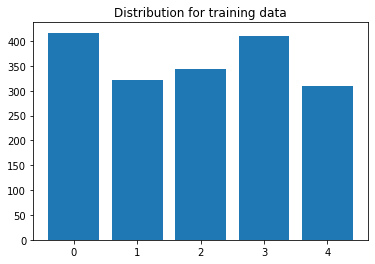

In [65]:
category, values = np.unique(train['label'].values, return_counts=True) #checking distribution
plt.title("Distribution for training data")
plt.bar(category,values)

<BarContainer object of 5 artists>

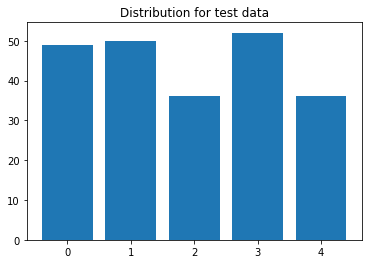

In [66]:
category, values = np.unique(test['label'].values, return_counts=True)
plt.title("Distribution for test data")
plt.bar(category,values)

<BarContainer object of 5 artists>

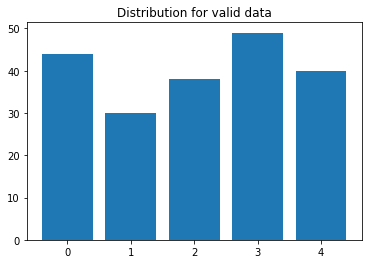

In [67]:
category, values = np.unique(valid['label'].values, return_counts=True)
plt.title("Distribution for valid data")
plt.bar(category,values)

In [27]:
# train.to_csv('/home/edshkim98/nlp/classification/train.csv', index=False)
# valid.to_csv('/home/edshkim98/nlp/classification/valid.csv', index=False)
# test.to_csv('/home/edshkim98/nlp/classification/test.csv', index=False)
# train2, test2 = train.copy(), test.copy()

In [68]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import spacy

# FIELDS

In [69]:
# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('text', text_field)]

/home/edshkim98/env/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [70]:
train=pd.read_csv('/home/edshkim98/nlp/classification/train.csv')
valid=pd.read_csv('/home/edshkim98/nlp/classification/valid.csv')
test=pd.read_csv('/home/edshkim98/nlp/classification/test.csv')

# WORD EMBEDDINGS

In [71]:
from torchtext.vocab import GloVe

# DATALOADER

In [72]:
# TabularDataset
train_data, valid_data,test_data = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv', test='test.csv'
                                          ,format='CSV', fields=fields, skip_header=True)
# Iterators
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_iter = BucketIterator(train_data, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid_data, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
sample_iter = BucketIterator(test_data, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

if word_embd:
    glove = GloVe(name='6B', dim=300)
    text_field.build_vocab(train_data, min_freq=3,vectors = glove)
else:
    text_field.build_vocab(train_data, min_freq=3)


/home/edshkim98/env/lib/python3.7/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/edshkim98/env/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/edshkim98/env/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further informat

In [73]:
len(text_field.vocab)

11661

# UTILS

In [74]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer, device):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

# LOSS FUNCTIONS

In [75]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=torch.tensor([0.8,1.0,1.0,0.8,1.0]), gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.weight = weight.to(device)

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight) 
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss
    

# TRAIN

In [86]:
def train(model,
          optimizer,
          train_loader = train_iter,
          valid_loader = valid_iter,
          loss_func = ls,
          num_epochs = 10,
          eval_every = len(train_iter),
          file_path = source_folder+'/pretrained/',
          best_valid_loss = float("Inf")):
    
    if ls == 'FOCAL':
        criterion = FocalLoss()
    else:
        criterion = nn.CrossEntropyLoss()
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    patience = 0
    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (text, text_len)), _ in train_loader:           
            labels = labels.long().to(device)
            titletext = text.to(device)
            titletext_len = text_len.to(device)
            output = model(titletext, titletext_len)
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():
                    
                  # validation loop
                    for (labels, (text, text_len)), _ in valid_loader:
                        labels = labels.long().to(device)
                        titletext = text.to(device)
                        titletext_len = text_len.to(device)
                        output = model(titletext, titletext_len)

                        loss = criterion(output, labels)
                        valid_running_loss += loss.item()
                        _, predicted = torch.max(output, 1)

                print(predicted)
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    patience = 0
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
                else:
                    patience +=1
                    print("Patience: {}/10".format(patience))
                    if patience == 10:
                        return 0
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [87]:
if model == 'LSTM':
    model = LSTM().to(device)
elif model == 'LSTM2':
    model = LSTM2().to(device)
elif model == 'GRU':
    model = GRU().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()

GRU(
  (embedding): Embedding(11661, 300)
  (lstm): GRU(300, 256, batch_first=True)
  (drop): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

In [88]:
train(model=model, optimizer=optimizer, loss_func = ls, num_epochs=100)


tensor([3, 3, 0, 2, 4, 4, 0, 1, 3], device='cuda:0')
Epoch [1/100], Step [113/11300], Train Loss: 1.6155, Valid Loss: 1.6074
Model saved to ==> /home/edshkim98/nlp/classification//pretrained//model.pt
Model saved to ==> /home/edshkim98/nlp/classification//pretrained//metrics.pt
tensor([1, 3, 0, 2, 3, 2, 0, 1, 4], device='cuda:0')
Epoch [2/100], Step [226/11300], Train Loss: 1.5556, Valid Loss: 1.5928
Model saved to ==> /home/edshkim98/nlp/classification//pretrained//model.pt
Model saved to ==> /home/edshkim98/nlp/classification//pretrained//metrics.pt
tensor([1, 3, 0, 2, 3, 2, 0, 1, 4], device='cuda:0')
Epoch [3/100], Step [339/11300], Train Loss: 1.4976, Valid Loss: 1.5826
Model saved to ==> /home/edshkim98/nlp/classification//pretrained//model.pt
Model saved to ==> /home/edshkim98/nlp/classification//pretrained//metrics.pt
tensor([1, 3, 0, 2, 3, 2, 0, 1, 4], device='cuda:0')
Epoch [4/100], Step [452/11300], Train Loss: 1.4467, Valid Loss: 1.5703
Model saved to ==> /home/edshkim98/nlp

0

# PLOTTING

Model loaded from <== /home/edshkim98/nlp/classification/pretrained/metrics.pt


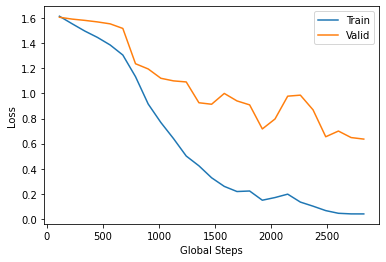

In [89]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

# EVALUATION

Model loaded from <== /home/edshkim98/nlp/classification/pretrained/model.pt
Classification Report:
              precision    recall  f1-score   support

           0     0.8889    0.7805    0.8312        41
           1     0.7143    0.6944    0.7042        36
           2     0.7600    0.9048    0.8261        42
           3     0.9556    0.9348    0.9451        46
           4     0.7714    0.7500    0.7606        36

    accuracy                         0.8209       201
   macro avg     0.8180    0.8129    0.8134       201
weighted avg     0.8249    0.8209    0.8208       201



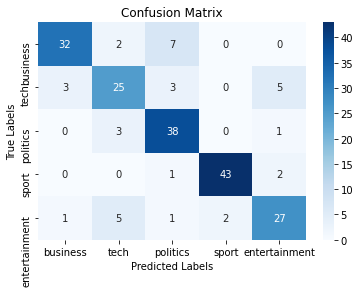

In [90]:
labels = {"business":0,"tech":1, "politics":2, "sport":3, "entertainment":4}

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (text, text_len)), _ in test_loader:           
            labels = labels.long().to(device)
            titletext = text.to(device)
            titletext_len = text_len.to(device)
            output = model(titletext, titletext_len)

            _, predicted = torch.max(output, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, digits=4))
    
    cm = confusion_matrix(y_true, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['business', 'tech', 'politics','sport','entertainment'])
    ax.yaxis.set_ticklabels(['business', 'tech', 'politics','sport','entertainment'])
    
    
best_model = model
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer,device=device)
evaluate(best_model, valid_iter)

# Testing in cpu

In [91]:
def test_single(model, test_loader):
    labels_dict = {0:"business",1:"tech", 2:"politics", 3:"sport", 4:"entertainment"}
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (text, text_len)), _ in test_loader:           
            labels = labels.long()#.to(device)
            titletext = text#.to(device)
            titletext_len = text_len#.to(device)
            output = model(titletext, titletext_len)

            _, predicted = torch.max(output, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())
    print(labels_dict[int(predicted)])
    
def test_whole(model, test_loader, device):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (text, text_len)), _ in test_loader:           
            labels = labels.long().to(device)
            titletext = text.to(device)
            titletext_len = text_len.to(device)
            output = model(titletext, titletext_len)

            _, predicted = torch.max(output, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['business', 'tech', 'politics','sport','entertainment'])
    ax.yaxis.set_ticklabels(['business', 'tech', 'politics','sport','entertainment'])

In [92]:
best_model = model#LSTM().to(device)
load_checkpoint(destination_folder + '/model.pt', best_model, optimizer,device=device)
best_model

Model loaded from <== /home/edshkim98/nlp/classification/pretrained/model.pt


GRU(
  (embedding): Embedding(11661, 300)
  (lstm): GRU(300, 256, batch_first=True)
  (drop): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

/home/edshkim98/env/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0     0.8485    0.7179    0.7778        39
           1     0.7800    0.8478    0.8125        46
           2     0.7500    0.8780    0.8090        41
           3     0.9661    0.9500    0.9580        60
           4     0.8485    0.7568    0.8000        37

    accuracy                         0.8430       223
   macro avg     0.8386    0.8301    0.8314       223
weighted avg     0.8479    0.8430    0.8429       223



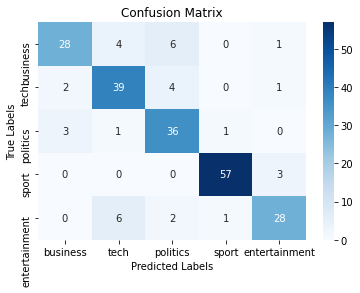

In [93]:
test_whole(best_model, sample_iter,device=device)